## Testing GravNet on a toy model example

Toy model where GravNet is classifying gaussian blobs in 3D space

### What the Toy GravNet Script Does

The script generates synthetic “calorimeter-like” events consisting of 2D Gaussian blobs (clusters) plus noise, where each point (hit) has features `(x, y, energy)` and a ground-truth cluster label. The synthetic data illustrates a single ECal layer

These hits are treated as nodes in a graph. The `GravNetConv` layers dynamically construct a k-nearest-neighbor graph in a learned latent space and perform message passing between neighboring nodes. This allows each hit to aggregate information from nearby hits.

The model is trained as a node-classification task: for each hit, it predicts which cluster it belongs to (or noise). During training, cross-entropy loss is minimized between predicted labels and true cluster IDs.

In summary, the script implements a Graph Neural Network (GNN) that learns to cluster spatially distributed hits by dynamically building graphs and propagating information between neighbors.


In [3]:
# Cell 2 — imports + extended sanity check
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GravNetConv

print("torch:", torch.__version__)
print("torch cuda version:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Verify GravNet layer instantiates
layer = GravNetConv(
    in_channels=3,
    out_channels=32,
    space_dimensions=2,
    propagate_dimensions=16,
    k=16
)

print("GravNetConv OK")


torch: 2.8.0+cu128
torch cuda version: 12.8
cuda available: False
device count: 0
GravNetConv OK


### Generating synthetic data - Gaussian blobs in 3D space

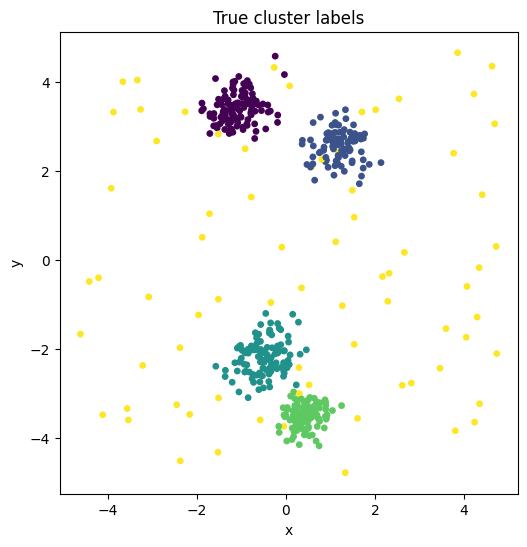

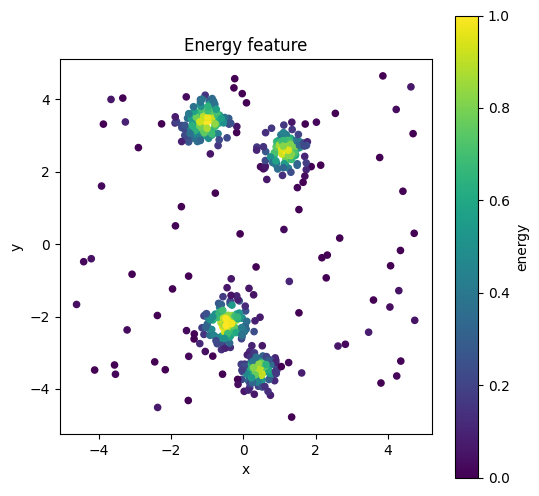

In [6]:
# Cell 3 — synthetic event generator (blobs + noise), node labels = cluster-id or noise
def make_blob_event(
    n_points=400,
    n_clusters=3,
    noise_frac=0.10,
    sigma_range=(0.15, 0.45),
    center_range=(-4.0, 4.0),
    seed=None,
):
    """
    Returns a PyG Data object:
      x: [N, F] features (x, y, energy)
      y: [N] integer labels in {0..n_clusters-1} for blobs, and n_clusters for noise
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    n_noise = int(round(n_points * noise_frac))
    n_sig = n_points - n_noise

    # allocate per-cluster counts
    counts = rng.multinomial(n_sig, [1.0 / n_clusters] * n_clusters)

    centers = rng.uniform(center_range[0], center_range[1], size=(n_clusters, 2))
    sigmas = rng.uniform(sigma_range[0], sigma_range[1], size=(n_clusters,))

    pts = []
    labels = []

    for cid in range(n_clusters):
        c = centers[cid]
        s = sigmas[cid]
        xyc = rng.normal(loc=c, scale=s, size=(counts[cid], 2))
        pts.append(xyc)
        labels.append(np.full((counts[cid],), cid, dtype=np.int64))

    if n_noise > 0:
        # uniform noise across a somewhat larger box
        noise = rng.uniform(center_range[0] * 1.2, center_range[1] * 1.2, size=(n_noise, 2))
        pts.append(noise)
        labels.append(np.full((n_noise,), n_clusters, dtype=np.int64))

    xy = np.concatenate(pts, axis=0)
    y = np.concatenate(labels, axis=0)

    # shuffle
    perm = rng.permutation(xy.shape[0])
    xy = xy[perm]
    y = y[perm]

    # a simple "energy" feature: higher near cluster centers, low for noise
    # (this is synthetic, but mimics calorimeter-like scalar info)
    energy = np.zeros((xy.shape[0],), dtype=np.float32)
    for cid in range(n_clusters):
        c = centers[cid]
        d2 = np.sum((xy - c) ** 2, axis=1)
        energy += np.exp(-d2 / (2.0 * (sigmas[cid] ** 2 + 1e-6))).astype(np.float32)
    energy = energy / (energy.max() + 1e-6)
    energy = energy + 0.05 * rng.normal(size=energy.shape).astype(np.float32)
    energy = np.clip(energy, 0.0, 1.0)

    x = np.concatenate([xy.astype(np.float32), energy[:, None]], axis=1)  # [N, 3]

    data = Data(
        x=torch.from_numpy(x),
        y=torch.from_numpy(y),
    )
    return data

### PLOT SYNTHETIC DATA

def plot_event_labels(data, title="True cluster labels"):
    xy = data.x[:, :2].cpu().numpy()
    labels = data.y.cpu().numpy()

    plt.figure(figsize=(6,6))
    plt.scatter(xy[:,0], xy[:,1], c=labels, s=15)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.gca().set_aspect("equal")
    plt.show()

sample = make_blob_event(n_points=500, n_clusters=4, noise_frac=0.15, seed=42)
plot_event_labels(sample)

def plot_event_energy(data, title="Energy feature"):
    xy = data.x[:, :2].cpu().numpy()
    energy = data.x[:, 2].cpu().numpy()

    plt.figure(figsize=(6,6))
    sc = plt.scatter(xy[:,0], xy[:,1], c=energy, s=20)
    plt.colorbar(sc, label="energy")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.gca().set_aspect("equal")
    plt.show()

plot_event_energy(sample)



### Build training and validation datasets 

In [7]:
# Cell 4 — build train/val datasets
def make_dataset(n_events, seed=0):
    rng = np.random.default_rng(seed)
    dataset = []
    for i in range(n_events):
        # Slightly vary event sizes and #clusters
        n_points = int(rng.integers(250, 650))
        n_clusters = int(rng.integers(2, 5))  # 2..4
        noise_frac = float(rng.uniform(0.05, 0.20))
        dataset.append(
            make_blob_event(
                n_points=n_points,
                n_clusters=n_clusters,
                noise_frac=noise_frac,
                seed=int(rng.integers(0, 10_000_000)),
            )
        )
    return dataset

train_data = make_dataset(800, seed=1)
val_data   = make_dataset(200, seed=2)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

# We'll predict up to 5 classes: {0..3} clusters + {4} noise
# Events may have fewer clusters; labels above their true count won't appear.
NUM_CLASSES = 5

print(len(train_data), len(val_data))


800 200


### Define model: 2x GravNet + MLP head classifier

In [8]:
# Cell 5 — model: 2x GravNet + MLP head (node classification)
class GravNetToy(nn.Module):
    def __init__(self, in_dim=3, hidden=64, space_dim=2, prop_dim=32, k=24, num_classes=5, dropout=0.1):
        super().__init__()
        self.gn1 = GravNetConv(in_dim, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)
        self.gn2 = GravNetConv(hidden, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes),
        )

    def forward(self, data):
        x = data.x
        batch = getattr(data, "batch", None)

        x = self.gn1(x, batch)
        x = F.relu(x)
        x = self.gn2(x, batch)
        x = F.relu(x)

        logits = self.head(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GravNetToy(in_dim=3, hidden=64, space_dim=2, prop_dim=32, k=24, num_classes=NUM_CLASSES).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

model


GravNetToy(
  (gn1): GravNetConv(3, 64, k=24)
  (gn2): GravNetConv(64, 64, k=24)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)

### Training/Eval helper functions

In [9]:
# Cell 6 — training/eval helpers
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0

    for data in loader:
        data = data.to(device)
        logits = model(data)
        loss = F.cross_entropy(logits, data.y, reduction="mean")
        pred = logits.argmax(dim=-1)

        total += data.y.numel()
        correct += (pred == data.y).sum().item()
        total_loss += loss.item() * data.y.numel()

    return total_loss / total, correct / total

def train_one_epoch(loader):
    model.train()
    total = 0
    total_loss = 0.0

    for data in loader:
        data = data.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(data)
        loss = F.cross_entropy(logits, data.y, reduction="mean")
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        total += data.y.numel()
        total_loss += loss.item() * data.y.numel()

    return total_loss / total


### Run training

In [10]:
# Cell 7 — run training
import time

history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, 21):
    t0 = time.time()
    tr_loss = train_one_epoch(train_loader)
    va_loss, va_acc = evaluate(val_loader)
    dt = time.time() - t0

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f} | {dt:.1f}s")


epoch 01 | train_loss 1.3846 | val_loss 1.3197 | val_acc 0.3590 | 17.7s
epoch 02 | train_loss 1.2969 | val_loss 1.2941 | val_acc 0.3493 | 17.3s
epoch 03 | train_loss 1.2841 | val_loss 1.2929 | val_acc 0.3476 | 19.4s
epoch 04 | train_loss 1.2810 | val_loss 1.2900 | val_acc 0.3420 | 17.5s
epoch 05 | train_loss 1.2823 | val_loss 1.2924 | val_acc 0.3410 | 18.2s
epoch 06 | train_loss 1.2788 | val_loss 1.2882 | val_acc 0.3350 | 16.4s
epoch 07 | train_loss 1.2775 | val_loss 1.2964 | val_acc 0.3303 | 16.7s
epoch 08 | train_loss 1.2736 | val_loss 1.2862 | val_acc 0.3402 | 16.0s
epoch 09 | train_loss 1.2753 | val_loss 1.2879 | val_acc 0.3402 | 15.1s
epoch 10 | train_loss 1.2726 | val_loss 1.2919 | val_acc 0.3172 | 15.4s
epoch 11 | train_loss 1.2725 | val_loss 1.2875 | val_acc 0.3474 | 15.4s
epoch 12 | train_loss 1.2718 | val_loss 1.2844 | val_acc 0.3447 | 16.2s
epoch 13 | train_loss 1.2708 | val_loss 1.2979 | val_acc 0.3296 | 19.0s
epoch 14 | train_loss 1.2695 | val_loss 1.2826 | val_acc 0.3443 

### Plot

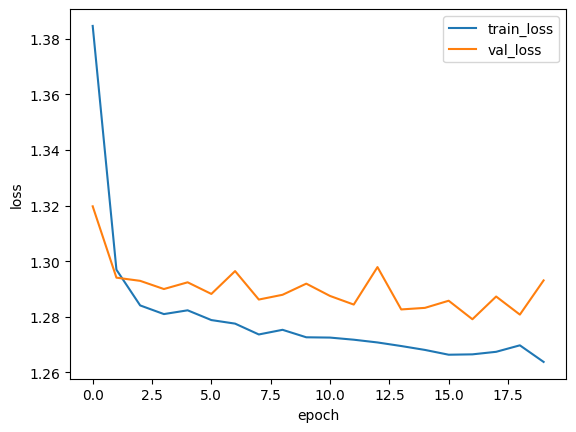

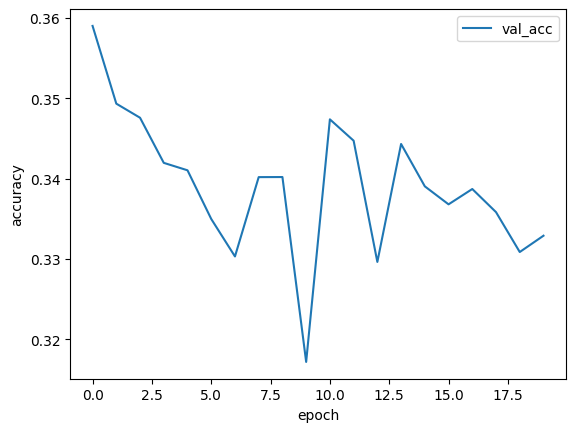

In [11]:
# Cell 8 — plot curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


### Visualisation

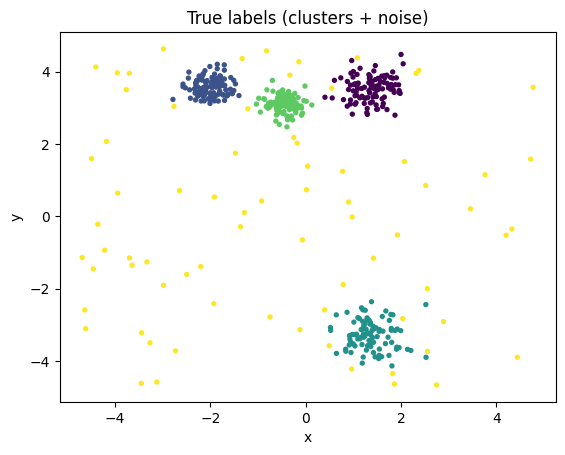

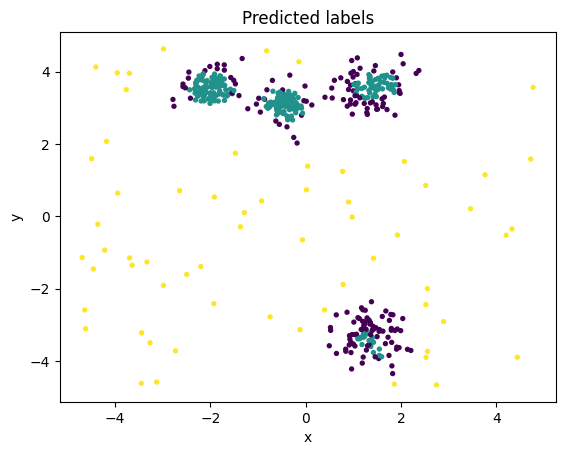

In [12]:
# Cell 9 — visualize one event: true vs predicted labels (2D scatter)
@torch.no_grad()
def predict_event(data):
    model.eval()
    data = data.to(device)
    logits = model(data)
    pred = logits.argmax(dim=-1).cpu()
    return pred

# pick a fresh event with a fixed seed for repeatability
sample = make_blob_event(n_points=500, n_clusters=4, noise_frac=0.15, seed=12345)
pred = predict_event(sample)

xy = sample.x[:, :2].numpy()
y_true = sample.y.numpy()
y_pred = pred.numpy()

def scatter_labels(xy, labels, title):
    plt.figure()
    plt.scatter(xy[:, 0], xy[:, 1], s=8, c=labels)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

scatter_labels(xy, y_true, "True labels (clusters + noise)")
scatter_labels(xy, y_pred, "Predicted labels")


### Extra: make it more reconstruction-like

In [13]:
# Cell 10 — (optional) make it more "reco-like": ignore noise label in the loss
# This is often useful if you want the model to focus on assigning shower hits and treat noise separately.

IGNORE_NOISE = True
noise_label = NUM_CLASSES - 1  # by construction we used last class as noise

def train_one_epoch_masked(loader):
    model.train()
    total = 0
    total_loss = 0.0

    for data in loader:
        data = data.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(data)

        if IGNORE_NOISE:
            mask = (data.y != noise_label)
            loss = F.cross_entropy(logits[mask], data.y[mask], reduction="mean")
            n = int(mask.sum().item())
        else:
            loss = F.cross_entropy(logits, data.y, reduction="mean")
            n = data.y.numel()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        total += n
        total_loss += loss.item() * n

    return total_loss / max(total, 1)

# Example: fine-tune 5 epochs with masked loss
for epoch in range(1, 6):
    tr_loss = train_one_epoch_masked(train_loader)
    va_loss, va_acc = evaluate(val_loader)
    print(f"[masked] epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f}")


[masked] epoch 01 | train_loss 1.2241 | val_loss 1.4758 | val_acc 0.3380
[masked] epoch 02 | train_loss 1.2130 | val_loss 1.5301 | val_acc 0.3408
[masked] epoch 03 | train_loss 1.2118 | val_loss 1.5332 | val_acc 0.3379
[masked] epoch 04 | train_loss 1.2152 | val_loss 1.5672 | val_acc 0.3322
[masked] epoch 05 | train_loss 1.2095 | val_loss 1.5759 | val_acc 0.3320
